# Computing ephemerides of Solar System Objects

The purpose of these exerice is to get used to retrieve data from an API (Application Public Interface).


In [78]:
import io
import requests
import json
from astropy.coordinates import Angle

import rocks
import pandas as pd
import time as t

import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

## Define the parameters of the query



In [1]:
# When we observe
epoch = "2024-01-01T00:00:00"
nbd = 180
step = "5d"

# What we observe
targets = ["Pallas", 3, "vesta", "2003 EL61"]

# Where are we observing from
observer = "309"  # Paranal, see https://www.minorplanetcenter.net/iau/lists/ObsCodesF.html

## 1. Direct API query on IMCCE/Miriade

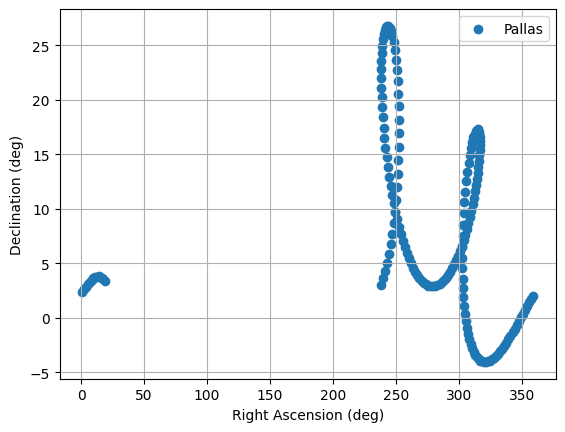

In [81]:
# Service URL
url = "https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php?"


# Query parameters
# The request package that we will use will create the full URL for us from the dictionary below
params = {
    "-name": targets[0],
    "-nbd": nbd,
    "-step": step,
    "-mime": "json",
    "-loc": observer,
    "-tscale": "UTC",
    "-from": "Student_at_Les_Houches",
}

# Query the service
try:
    r = requests.post(url, params=params, timeout=2000)
except requests.exceptions.ReadTimeout:
    print("Request timed out")

# Extract results
result = json.loads(r.content)

# Get ephemerides in pands DataFrame
eph = pd.DataFrame.from_dict(result["data"])

# Convert RA/Dec from hours/degrees to degrees
coords = SkyCoord(eph["RA"], eph["DEC"], unit=("hour", "deg"))
eph["RA_deg"] = coords.ra.degree
eph["DEC_deg"] = coords.dec.degree

# Plot the trajectory
fig, ax = plt.subplots()
ax.scatter(eph["RA_deg"], eph["DEC_deg"], label=targets[0])
ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.grid()
ax.legend()

The result of the query contains several items, including information on the SSO, the signification of each columns, the unit, the reference frame, etc:

In [ ]:
result.keys()

dict_keys(['sso', 'coosys', 'ephemeris', 'data', 'datacol', 'unit'])

In [ ]:
result["sso"]

{'num': 136108,
 'name': 'Haumea',
 'type': 'asteroid',
 'parameters': {'source': 'ASTORB',
  'author': 'L.H. Wasserman',
  'physical_model': '',
  'diameter': 0.0,
  'number_observations': 4161,
  'orbital_arc': 25124,
  'ceu': 0.013,
  'ceu_rate': 6.3e-06,
  'orbital_period': 102609.98688585896,
  'mass': 0.0,
  'dynamical_class': 'KBO>SDO',
  'taxonomy': {'class': '?', 'param': '?', 'source': '?'}}}

In [ ]:
result["unit"]

{'diameter': 'km',
 'orbital_arc': 'days',
 'ceu': 'arsec',
 'ceu_rate': 'arcsec/day',
 'orbital_period': 'day',
 'mass': 'kg',
 'RA': 'h',
 'DEC': 'deg',
 'Dobs': 'au',
 'VMag': 'mag',
 'Phase': 'deg',
 'Elong.': 'deg',
 'dRAcosDEC': 'arcsec/min',
 'dDEC': 'arcsec/min',
 'RV': 'km/s'}

etc.

We can easily script this for several targets

Request of ephemerides for Pallas took 0.9 seconds
Request of ephemerides for Juno took 0.7 seconds
Request of ephemerides for Vesta took 0.7 seconds


Request of ephemerides for Haumea took 1.7 seconds


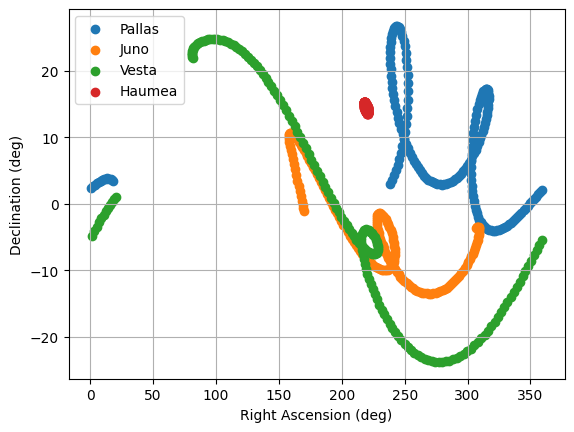

In [79]:
fig, ax = plt.subplots()

for i, sso in enumerate(targets):
    # Update the target of the query, but check first its designation
    ids = rocks.id(sso)
    params["-name"] = ids[0]

    # Query the service
    t0 = t.time()
    try:
        r = requests.post(url, params=params, timeout=2000)
    except requests.exceptions.ReadTimeout:
        print("Request timed out")
    t1 = t.time()
    print(f"Request of ephemerides for {ids[0]} took {t1-t0:.1f} seconds")

    # Extract results
    result = json.loads(r.content)

    # Get ephemerides in pands DataFrame
    eph = pd.DataFrame.from_dict(result["data"])

    # Convert RA/Dec from hours/degrees to degrees
    coords = SkyCoord(eph["RA"], eph["DEC"], unit=("hour", "deg"))
    eph["RA_deg"] = coords.ra.degree
    eph["DEC_deg"] = coords.dec.degree

    # Plot the trajectory
    ax.scatter(eph["RA_deg"], eph["DEC_deg"], label=params["-name"])


ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.grid()
ax.legend()

Whenever you want to use an API, have a quick look at the documentation to see what it can do and how to use it!
In the present case of Miriade, the documentation is available at https://ssp.imcce.fr/webservices/miriade/api/ephemcc/

For instance, you can easily switch to **ecliptic** coordinates (*rplane* keyword), change the list of reported columns ([*tcoor* keyword](https://ssp.imcce.fr/webservices/miriade/api/ephemcc/#output-results)), compute magnitude in different filters ([*colors* keyword](https://ssp.imcce.fr/webservices/miriade/howto/ephemcc/#howto-filters)), even in the thermal infrared
([*thermalFlux* keyword](https://ssp.imcce.fr/webservices/miriade/howto/ephemcc/#howto-thermalflux)).

## 2. Using astroquery wrapper to query MPC

In [82]:
from astroquery.mpc import MPC

In [94]:
# Choose a target
i = 0

# Update the target of the query, but check first its designation
ids = rocks.id(targets[i])

t0 = t.time()
try:
    eph = MPC.get_ephemeris(
        ids[0], step=step, start=epoch, number=nbd, location=observer
    )
except requests.exceptions.ReadTimeout:
    print("Request timed out")
t1 = t.time()
print(f"Request of ephemerides for {ids[0]} took {t1-t0:.1f} seconds")

Request of ephemerides for Pallas took 0.1 seconds


The result here is an [<kbd>astropy</kbd>](https://www.astropy.org/) [Table](https://docs.astropy.org/en/stable/table/) object. It is in essence a matrix, that can be accessed by rows/columns. Each column is a [<kbd>Quantity</kbd>](https://docs.astropy.org/en/stable/api/astropy.units.Quantity.html#astropy.units.Quantity): it has a unit.

In [99]:
eph[:4]

Date,RA,Dec,Delta,r,Elongation,Phase,V,Proper motion,Direction,Azimuth,Altitude,Sun altitude,Moon phase,Moon distance,Moon altitude,Uncertainty 3sig,Unc. P.A.
,deg,deg,AU,AU,deg,deg,mag,arcsec / h,deg,deg,deg,deg,,deg,deg,arcsec,deg
Time,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,int64,int64,float64,float64
2024-01-01 00:00:00.000,230.0008333333333,1.1197222222222223,3.067,2.626,54.8,17.8,9.6,60.09,81.9,223,-60,-6,0.78,71,-40,0.0,81.6
2024-01-06 00:00:00.000,231.9408333333333,1.4322222222222223,3.026,2.639,57.9,18.4,9.6,59.05,79.9,219,-62,-6,0.32,25,-51,0.0,90.0
2024-01-11 00:00:00.000,233.83208333333332,1.8080555555555555,2.983,2.651,61.1,19.0,9.6,57.92,77.8,213,-63,-6,0.0,57,-9,0.0,81.0
2024-01-16 00:00:00.000,235.6695833333333,2.2483333333333335,2.938,2.663,64.3,19.4,9.6,56.71,75.5,208,-65,-6,0.26,122,40,0.0,80.7


An advantage of using a community-supported wrapper is that you do not have to figure out how to build the query nor how to decode the answer.

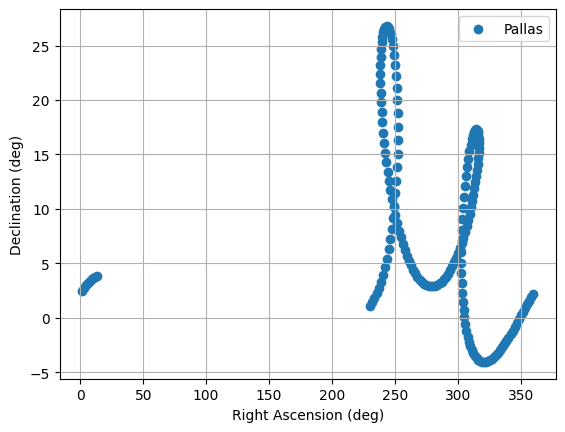

In [95]:
# Plot the trajectory
fig, ax = plt.subplots()
ax.scatter(eph["RA"], eph["Dec"], label=ids[0])
ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.grid()
ax.legend()

## Exercices

### Ex1. Plan your night of observations 

Let's start with a simple exercice, simply changing some parameters. Get the ephemerides for
- KBO Haumea
- On the night of 2024, February the 10th
- From La Silla observatory
- With a time step between points of 5 minutes

In [ ]:
# Code here

### Ex2. Cartesian coodinates

You are interested in the geometry of encounter between your favorite space mission (e.g. Lucy) and a potential flyby target (e.g., Patroclus). In such case, you would need the position of the target in heliocentric cartesian coordinates.

- Compute the trajectory of asteroids Patroclus from 2020 to 2030 in heliocentric ecliptic cartesian coordinates using Miriade.
- Plot its trajectory in a ecliptic (x,y) plane.
- (optional) Overplot the motion of planets Earth and Jupiter over the same time period

In [ ]:
# Code here!
